# py4DSTEM tutorial 4: Diffraction shift correction

Calibration is a vital step in any data analysis, and in 4D-STEM, there are quite a few calibrations which can be important: pixel sizes, elliptical distortions, rotational misalignment between real and diffraction space, diffraction shifts.  Which are necessary depends on the data itself, the analysis being performed, and desired measurement accuracy.

Here, we'll look at just one calibration: correcting overall translational shifts of the diffraction patterns which occur as the beam is scanned.  These shifts tend to scale with the scan size, so this calibration is most important when the field of veiw is large.

### Import packages, load data

In [2]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# Diffraction shift correction
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

In [3]:
# Load data

fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Sample_LFP_datacube.h5"
dc = py4DSTEM.file.io.read(fp)                                                # Get the datacube

fp = "/home/ben/Desktop/Sample_LFP_datacube_processing.h5"
browser = FileBrowser(fp)
braggpeaks_uncorrected = browser.get_dataobject('braggpeaks')
browser.close()

/home/ben/Data/20180905_FePO4_unlithiated/h5/Sample_LFP_datacube.h5 is a py4DSTEM file, v0.4. Reading...


### The Bragg vector map

We'll start by visualizing the problem.  Here we calculate the Bragg vector map - the sum of all the detected Bragg peak positions into a single array in the shape of the diffraction plane.  Ideally, this should look like a set of delta functions at the reciprocal lattice points of our crystal - but as you see below, it does not!

In [6]:
braggvectormap_uncorrected = get_bragg_vector_map(braggpeaks_uncorrected, dc.Q_Nx, dc.Q_Ny)

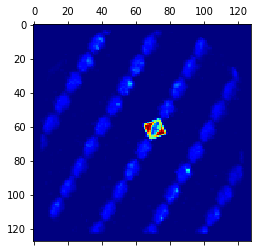

In [9]:
power = 0.4

fig,ax = plt.subplots()
ax.matshow(braggvectormap_uncorrected**power, cmap='jet')
plt.show()

### Measure diffraction shifts

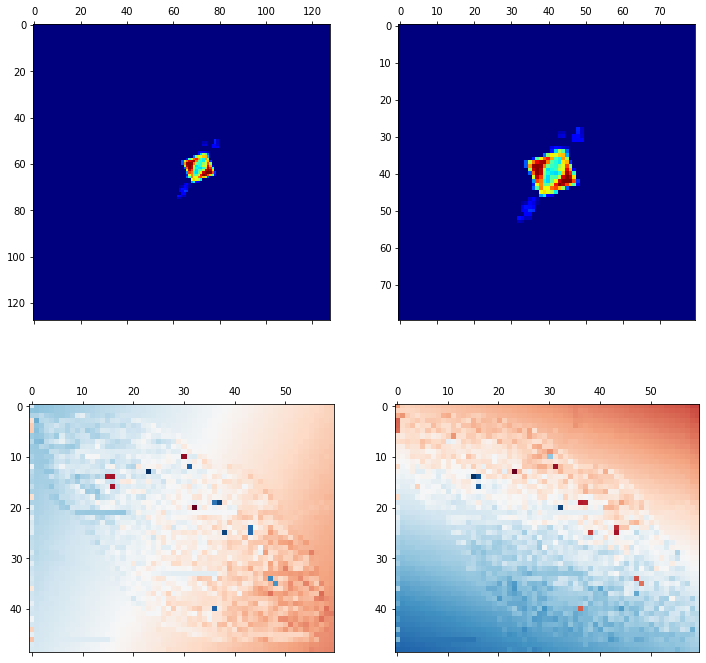

In [10]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks_uncorrected,
                                                                 dc.Q_Nx, dc.Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

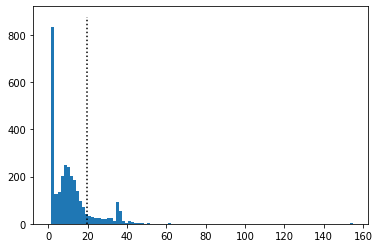

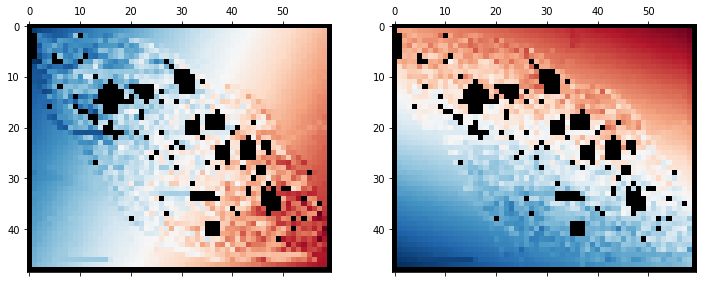

In [12]:
# Find outliers

n_sigma = 2
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

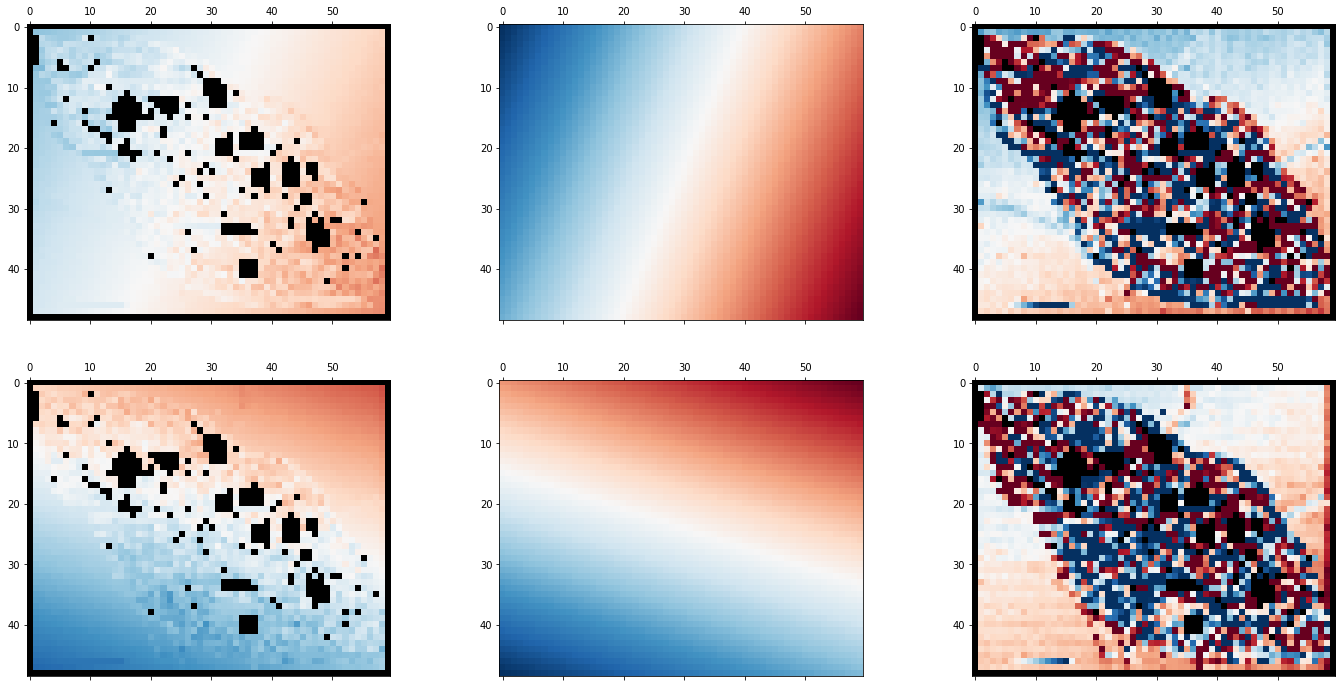

In [13]:
# Fit the diffraction shifts

fit_function = py4DSTEM.process.fit.plane        # Select fit type
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

### Correct diffraction shifts

In [14]:
# Apply shifts

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks_uncorrected, xshifts_fit, yshifts_fit)

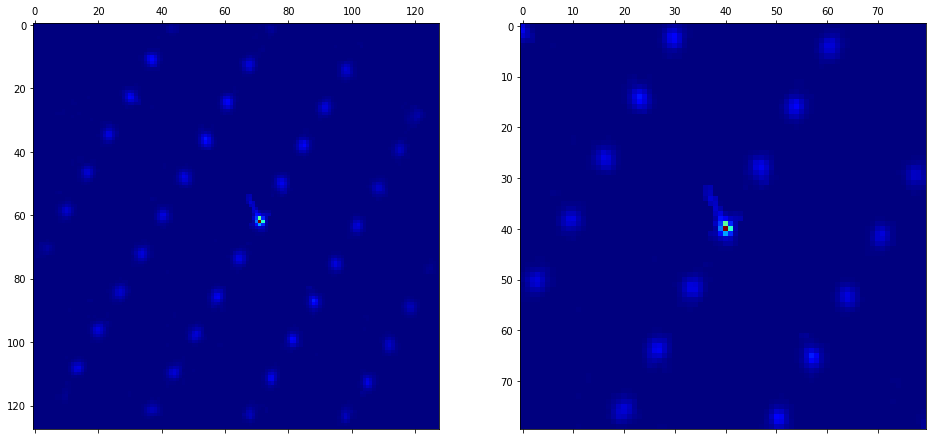

In [17]:
# Re-calculate Bragg vector map and show

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,dc.Q_Nx,dc.Q_Ny)
power = 0.4

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**power,cmap='jet')
plt.show()

### Save

In [18]:
# Store relevant data in  DataObjects

# Diffraction shifts
data = np.zeros((dc.R_Nx,dc.R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = RealSlice(data, slicelabels=('x_shifts','y_shifts'), name='diffraction_shifts')

# Corrected Bragg vector map
braggvectormap_corrected_diffslice = DiffractionSlice(braggvectormap_shiftcorrected, name='braggvectormap_shiftcorrected')

In [23]:
# Append to processing file

dataobjects = [diffractionshifts, braggvectormap_corrected_diffslice, braggpeaks_shiftcorrected]

fp = "/home/ben/Desktop/Sample_LFP_datacube_processing.h5"
append(dataobjects, fp)

Opening file /home/ben/Desktop/Sample_LFP_datacube_processing.h5...
Done.
